# Lab 3: 1D Finite Differences

<p><center>Connor Poetzinger</center></p>

In this lab we explore boundary value problems (BVP). We start by implementing an implementation of the Matlab backslash operator called the Thomas algorithm. We then implement a finite difference solver to solve a BVP using both the backslash operator and the Thomas algorithm. The results are compared to each other and a convergence study is preformed on the approximated solution. 

## Thomas Algorithm 

### Code Deliverable 

Write a function **thomas_solver** that takes as inputs vectors **a, b, c,** and **d**, and returns the solution **x**.

In [1]:
#import external modules 
import numpy as np

def thomas_solver(a, b, c, d):
    
    """
    The Thomas Algorithm is a simplified form of Gaussian elimination that 
    can be used to solve tridiagonal systems of equations.
    
    Input:
        a, b, c, d - numpy vectors that make up tridiagonal matrix and solution d 
    Output: 
        x - solution numpy vector
    """
    
    #initialize number of equations
    #this will be the length of vector d 
    n = len(d)
    
    #make a copy of each array 
    #can use the map function to map an array function to each variable 
    aa, bb, cc, dd = (x.astype(float) for x in (a, b, c, d))
    
    #loop for n iterations 
    for i in range(1, n):
        
        #apply the Thomas Algorithm 
        m = aa[i - 1] / bb[i - 1]
        bb[i] = bb[i] - m * cc[i - 1]
        dd[i] = dd[i] - m * dd[i - 1]
        
    #assign solution x to main diagonal b 
    x = bb
    x[-1] = dd[-1] / bb[-1]
    
    for i in range(n - 2, -1, -1):
        x[i] = (dd[i] - cc[i] * x[i + 1]) / bb[i]
        
    #return solution
    return x 

### Thomas Algorithm Test

Test the **thomas_solver** on the 10x10 linear system where the main diagonal is **3**, the off diagonals are **-1**, and the solution is a 1x10 column vector **2, 1, ... ,1, 2.**

In [2]:
#initialize arrays a b c and d
a = np.full([9], -1)
b = np.full([10], 3)
c = np.full([9], -1)
d = np.array([2,1,1,1,1,1,1,1,1,2])

#call thomas_solver function with arrays 
result = thomas_solver(a, b, c, d)
print(result)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [3]:
#compare against thomas solver
A = np.array([[3, -1, 0, 0, 0, 0, 0, 0, 0, 0],
             [-1, 3, -1, 0, 0, 0, 0, 0, 0, 0],
             [0, -1, 3, -1, 0, 0, 0, 0, 0, 0],
             [0, 0, -1, 3, -1, 0, 0, 0, 0, 0],
             [0, 0, 0, -1, 3, -1, 0, 0, 0, 0],
             [0, 0, 0, 0, -1, 3, -1, 0, 0, 0],
             [0, 0, 0, 0, 0, -1, 3, -1, 0, 0],
             [0, 0, 0, 0, 0, 0, -1, 3, -1, 0],
             [0, 0, 0, 0, 0, 0, 0, -1, 3, -1],
             [0, 0, 0, 0, 0, 0, 0, 0, -1, 3]])

d = np.array([2,1,1,1,1,1,1,1,1,2])
print(np.linalg.solve(A,d))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Finite Differences

### Code Deliverable

Write a finite difference code using python's scipy built-in **spdiags** to generate $A_{i,j}$ in sparse form. Use **BOTH** python's numpy backslash operator and the **thomas_solver** to solve for **U**.

In [4]:
#import external modules
from scipy import sparse

def finite_difference_sparse(f, a, b, ua, ub, N):
    
    """
    This function provides the approximate solution given the derivative of a function (f),
    the bounded x values (a, b), the initial boundary conditions (ua, ub) and the number of approx (N)
    
    Input:
        f - lambda function that is the derivative you are trying to approximate 
        a - starting x value 
        b - ending x value 
        ua - starting boundary value condition 
        ub - ending boundary value condition 
        N - number of iterations to approx
    Output:
        U_backslash - approximations using python backslash operator 
        U_thomas - approximations using thomas_solver function
        x - interior discretization points 
    """
    
    #split the domian [a,b] into N+1 equally spaced nodes 
    #x = a:b:h with h  = (b-a)/N+1
    h = (b - a) / (N + 1)

    #compute grid points 
    x = np.arange(a, b, h)

    #compute right hand side and set boundary conditions
    f = f(x)*(-h**2)
    f[0], f[-1] = f[0] - ua, f[-1] - ub

    #define vectors for main diagonal and off diagonals 
    main_diag = -2*np.ones((N+1, 1)).ravel()
    off_diag = 1*np.ones((N, 1)).ravel()

    #create sparse matrix 
    diagonals = [main_diag, off_diag, off_diag]
    A = sparse.diags(diagonals, [0,-1,1], shape=(N+1,N+1)).toarray()

    #solve matrix system using backslash and thomas algorithm 
    U_backslash = np.linalg.solve(A, f)
    U_thomas = thomas_solver(off_diag, main_diag, off_diag, f)
    
    #rreturn approximations and interior points 
    return U_backslash, U_thomas, x

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def generateApproxPlots(xf, x, UB, UT, exactF):
    
    """
    This function plots the approximate solutions 
    versus the exact solution. 
    
    Input:
        xf - vector of interior points for exact solution 
        x - vector of interior points for approximate solutions 
        UB - approximation for the backslash opperator 
        UT - approximation for the thomas algorithm function
        exactF - lambda function that provides the exact solution
    Output:
        plot showing the approximate vs exact solution 
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(xf, exactF(xf), label='Exact')
    ax[0].plot(x, UB, 'o', label='Backslash')
    ax[0].plot(x, UT, 'x', label='Thomas')
    ax[0].set_title('Approximations vs Exact', fontsize=18)
    ax[0].legend()
    ax[1].plot(x, UB, 'o', label='Backslash')
    ax[1].plot(x, UT, '--', label='Thomas')
    ax[1].set_title('Difference between approximations', fontsize=18)
    ax[1].legend()
    plt.show()

### Exercise

Given the exact solution, 
\begin{equation*}
u(x) = x^3 - sin(x) + 5
\end{equation*}
\begin{equation*}
x = [0,2\pi]
\end{equation*}
we can generate
\begin{equation*}
-f(x) = u^{''}(x)=-(6x+sin(x)),
\end{equation*}
and the boundary conditions,
\begin{equation*}
u_a=u(0)=5,
\end{equation*}
\begin{equation*}
u_b=u(2\pi)=8\pi^3+5
\end{equation*}
Appy the code to the $u^{''}$ when *N = 64*. Plot **U_backslash and U_thomas** vs **x** against the exact solution at each x. Report the difference between **U_backslash and U_thomas**.

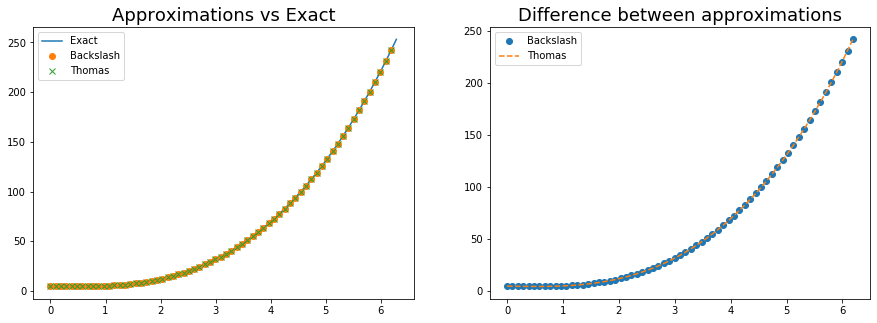

In [6]:
#initial conditions 
N = 64
a = 0
b = np.pi * 2
ua = 5
ub = 8 * np.pi**3 + 5

#Define mesh and lambda functions for 
#approximate and exact 
xf = np.linspace(a, b, N)
exact = lambda x: x**3 - np.sin(x) + 5
func = lambda x: -6*x - np.sin(x)

#call finite difference function 
UB, UT, x = finite_difference_sparse(func, a, b, ua, ub, N)

#plot approximations vs exact
generateApproxPlots(xf, x, UB, UT, exact)

### Convergence study

Convergence study using *N = [4, 8, 16, 32, 64, 128]*, using the $\ell_2$ norm and the $\ell_{\infty}$ norm. Provide a *loglog* plot with both norms and state the convergence order in your report. I am using **U_backslash** to show the order of convergence.

In [7]:
def finiteDiffConvergence(func, a, b, ua, ub, h):
    
    """
    This function performs a convergence study 
    """

    #array of different values of N
    N = [4, 8, 16, 32, 64, 128]

    #initialize empty array to hold error
    err = []

    #loop through N values in Narray 
    for h in N:
        #call finite different functions 
        UB, UT, x = finite_difference_sparse(func, a, b, ua, ub, h)
        #find error from approximate value and exact 
        E = UB - exact(np.linspace(a, b, h+1))
        #append error to array 
        err.append(E)

    #calculate the l2 and linf norm 
    X = [np.linalg.norm(item, 2) for item in err]
    Y = [np.linalg.norm(item, np.inf) for item in err]
    
    #return norms 
    return X/np.sqrt(N), Y, N

In [8]:
def plotLoglog(X, Y, NN):
    """
    This function plots a convergence study on the approximated solutions 
    
    Inputs:
        X - l2 norm of approximated solution 
        Y - linf norm of the approximated solution 
        NN - array of N input sizes 
    """
    
    #calculate slope 
    m1 = (np.log(2.18868523/4.36864701))/(np.log(128/64))
    m2 = (np.log(5.675683733054939/11.178104970785938))/(np.log(128/64))
    txt = "\nSlope of the log log plot for l_2 norm " + str(round(m1,6)) + "\nSlope of the log log plot for l_inf norm " + str(round(m2,6))
    
    #plot convergence study 
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].loglog(NN, X)
    ax[0].set_xlabel('Step size N')
    ax[0].set_ylabel(r'$\ell_2$ norm of U_backslash')
    ax[0].set_title(r'Loglog plot for $\ell_2$ norm', fontsize=18)
    ax[1].loglog(NN, Y)
    ax[1].set_xlabel('Step size N')
    ax[1].set_ylabel(r'$\ell_{\infty}$ norm of U_backslash')
    ax[1].set_title(r'Loglog plot for $\ell_{\infty}$ norm', fontsize=18)
    fig.text(.5, .000005, txt, ha='center', fontsize=13)
    plt.show()

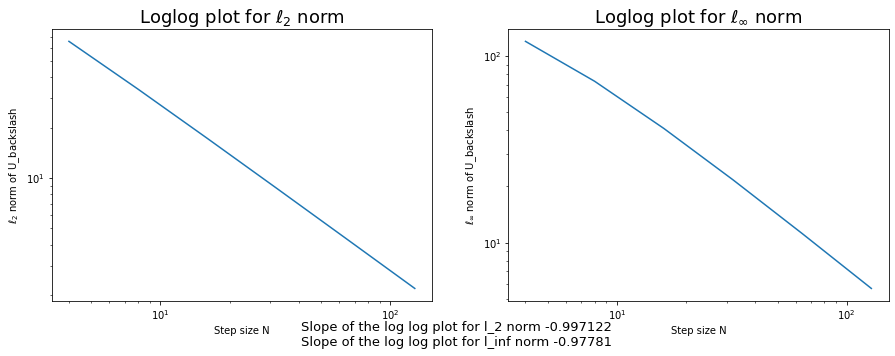

In [9]:
#perform and plot convergence study 
X, Y, NN = finiteDiffConvergence(func, a, b, ua, ub, N)
plotLoglog(X, Y, NN)